In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import wrangle_zillow as w
import warnings
warnings.filterwarnings("ignore")

# Experimenting more with zillow

In [13]:
df = w.get_zillow()

Total rows: 71789
Total columns: 69


In [14]:
df = w.handle_missing_values(df, 0.75, 0.75)

Total rows: 71786
Total columns: 30


In [17]:
# Filter rows based on 'logerror'
df = df[
    (df["logerror"] < df["logerror"].quantile(0.99))
    & (df["logerror"] > df["logerror"].quantile(0.005))
]

# Filter rows based on 'taxvaluedollarcnt'
df = df[df["taxvaluedollarcnt"] < df["taxvaluedollarcnt"].quantile(0.98)]

# Filter rows based on 'structuretaxvaluedollarcnt'
df = df[
    df["structuretaxvaluedollarcnt"] < df["structuretaxvaluedollarcnt"].quantile(0.99)
]

df.shape

(62571, 30)

In [29]:
# Single Family Homes
single_fam = [
    "Single Family Residential",
    "Condominium",
    "Residential General",
    "Manufactured, Modular, Prefabricated Homes",
    "Mobile Home",
    "Townhouse",
]

df = df[df["propertylandusedesc"].isin(single_fam)]

df.shape

(62571, 30)

In [31]:
df = df[
    [
        "bathroomcnt",
        "bedroomcnt",
        "finishedsquarefeet12",
        "fips",
        "latitude",
        "longitude",
        "yearbuilt",
        "taxvaluedollarcnt",
        "logerror",
    ]
]

In [32]:
w.check_columns(df)

Total rows: 62571
Total columns: 9


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,bathroomcnt,float64,18,0,0.0000,"[1.0, 2.0, 3.0, 2.5, 4.0, 1.5, 4.5, 0.0, 5.0, ...","[0.0, 10.0, 2.13093126208627]"
1,bedroomcnt,float64,11,0,0.0000,"[2.0, 3.0, 4.0, 1.0, 5.0, 0.0, 7.0, 6.0, 8.0, ...","[0.0, 10.0, 2.9202346134790877]"
2,finishedsquarefeet12,float64,3481,238,0.0038,"[1465.0, 1243.0, 2376.0, 1312.0, 1492.0, 2962....","[128.0, 7970.0, 1591.9866683779057]"
3,fips,float64,3,0,0.0000,"[6111.0, 6059.0, 6037.0]","[6037.0, 6111.0, 6049.400025570952]"
4,latitude,float64,51178,0,0.0000,"[34449266.0, 33886168.0, 34245180.0, 34185120....","[33339527.0, 34818767.0, 34010086.197855234]"
5,longitude,float64,49451,0,0.0000,"[-119281531.0, -117823170.0, -118240722.0, -11...","[-119448392.0, -117554636.0, -118191395.11882502]"
6,yearbuilt,float64,130,125,0.0020,"[1967.0, 1962.0, 1970.0, 1964.0, 1982.0, 1950....","[1878.0, 2016.0, 1968.9408769176569]"
7,taxvaluedollarcnt,float64,40987,0,0.0000,"[464000.0, 564778.0, 145143.0, 119407.0, 33106...","[3254.0, 1056917.0, 365107.5740199134]"
8,logerror,float64,62105,0,0.0000,"[0.0556190874015, 0.00538285304689, -0.1034096...","[-0.235495175954, 0.251513303406, 0.0063854151..."


In [44]:
train, validate, test = w.split_data(df)

train: 37542 (60% of 62571)
validate: 12514 (20% of 62571)
test: 12515 (20% of 62571)


In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def multi_scaler(train, val, test, scaled_features=None, scaler="mm"):
    """
    This function takes in 3 dataframes (train, val, test)
    and scales them using the specified scaler.

    Parameters:
    train (pandas.DataFrame): The training dataframe.
    val (pandas.DataFrame): The validation dataframe.
    test (pandas.DataFrame): The test dataframe.
    scaled_features (list): A list of column names to scale. If None, all numeric columns are scaled.
    scaler (str): The scaler to use. Must be one of "MM" (MinMaxScaler), "Standard" (StandardScaler), or "Robust" (RobustScaler).

    Returns:
    tuple: A tuple of the scaled dataframes (train_scaled, val_scaled, test_scaled).
    """
    if scaled_features is None:
        # If scaled_features is not defined, scale all numeric columns
        numeric_cols = train.select_dtypes(include=["number"]).columns.to_list()
        if len(numeric_cols) == 0:
            raise ValueError("No numeric columns to scale.")
        scaled_features = numeric_cols

    if scaler == "mm":
        scaler_obj = MinMaxScaler()
    elif scaler == "std":
        scaler_obj = StandardScaler()
    elif scaler == "rob":
        scaler_obj = RobustScaler()
    else:
        raise ValueError(
            "Invalid scaler. Must be one of 'MM', 'Standard', or 'Robust'."
        )

    # Fit the scaler on the training data
    scaler_obj.fit(train[scaled_features])
    train_scaled = train.copy()
    train_scaled[scaled_features] = scaler_obj.transform(train[scaled_features])

    # Fit/transofrm the scaler on validate
    scaler_obj.fit(val[scaled_features])
    val_scaled = val.copy()
    val_scaled[scaled_features] = scaler_obj.transform(val[scaled_features])

    # Fit/transform the scaler on test
    scaler_obj.fit(test[scaled_features])
    test_scaled = test.copy()
    test_scaled[scaled_features] = scaler_obj.transform(test[scaled_features])

    return train_scaled, val_scaled, test_scaled

In [54]:
scale = train.drop(columns=['taxvaluedollarcnt', 'latitude', 'longitude']).columns

train, validate, test = multi_scaler(train, validate, test, scale, scaler="std")

In [56]:
train_loc = train[['latitude','longitude','taxvaluedollarcnt']]

In [62]:
# Divide latitude and longitude by 1_000_000 to convert it from microdegrees to degrees
train_loc.latitude = train_loc.latitude / 1_000_000
train_loc.longitude = train_loc.longitude / 1_000_000

<Axes: >

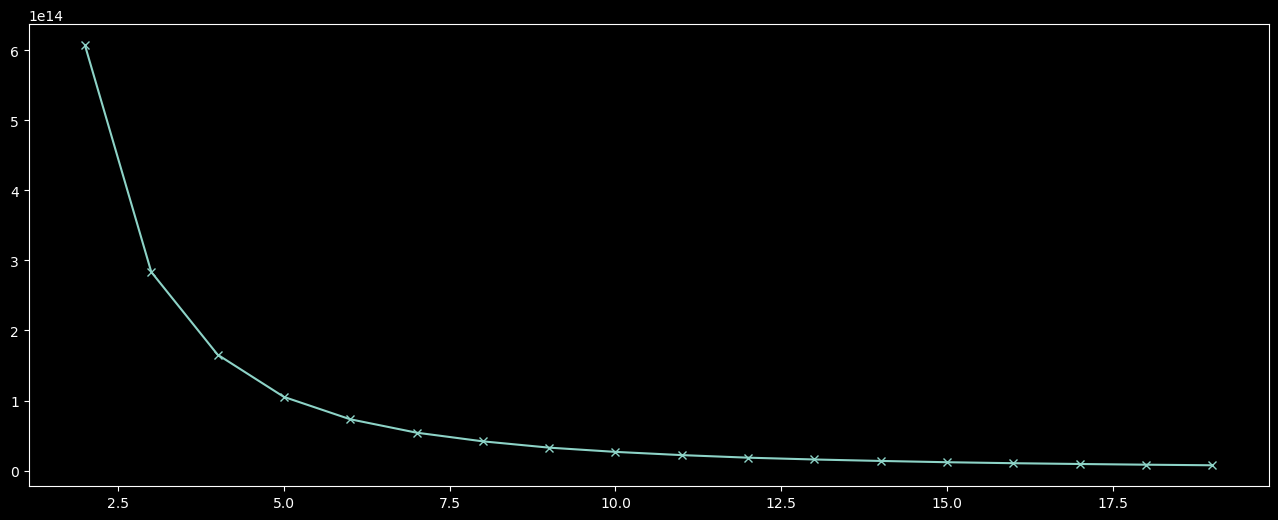

In [63]:
# Visualize intertia
plt.figure(figsize=(16,6))
pd.Series({k: KMeans(k).fit(train_loc).inertia_ for k in range(2, 20)}).plot(marker='x')

<Axes: xlabel='latitude', ylabel='longitude'>

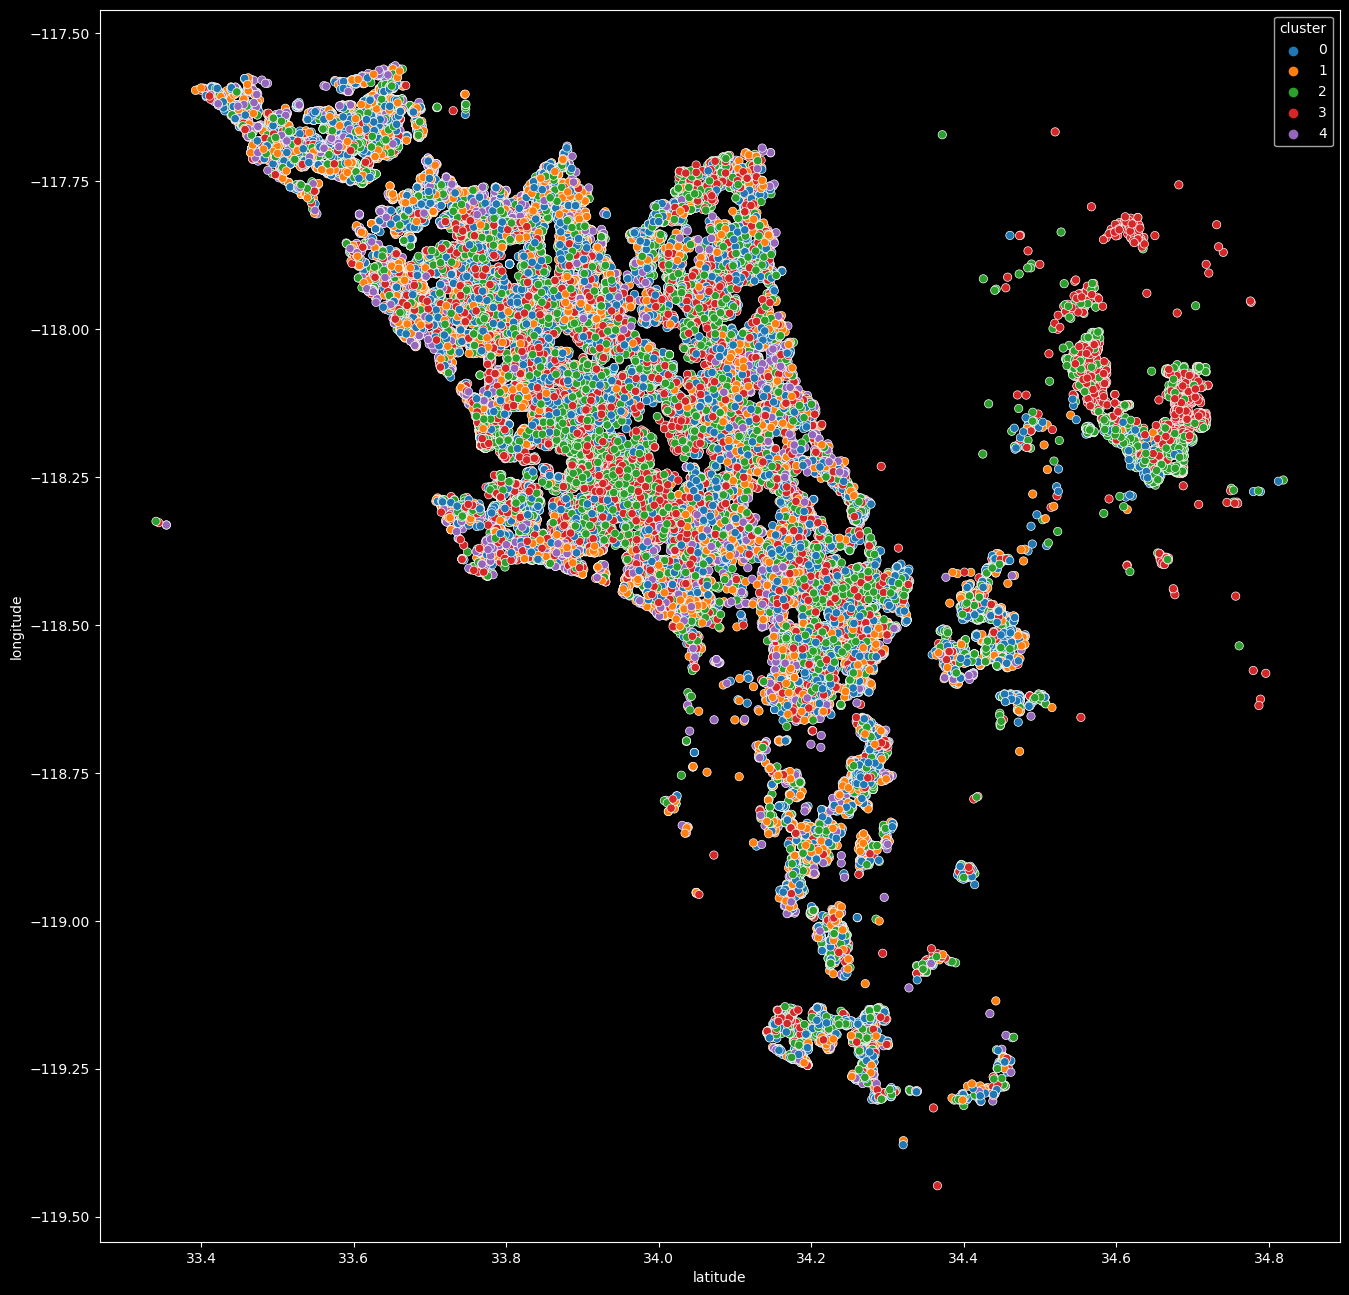

In [74]:
# Plot KMeans 5 on property value with x as lat and y as long
plt.figure(figsize=(16,16))
kmeans = KMeans(n_clusters=5)
kmeans.fit(train_loc.drop(columns=['latitude', 'longitude']))
train_loc['cluster'] = kmeans.predict(train_loc.drop(columns=['latitude', 'longitude']))
sns.scatterplot(x='latitude', y='longitude', data=train_loc, hue='cluster', palette='tab10')


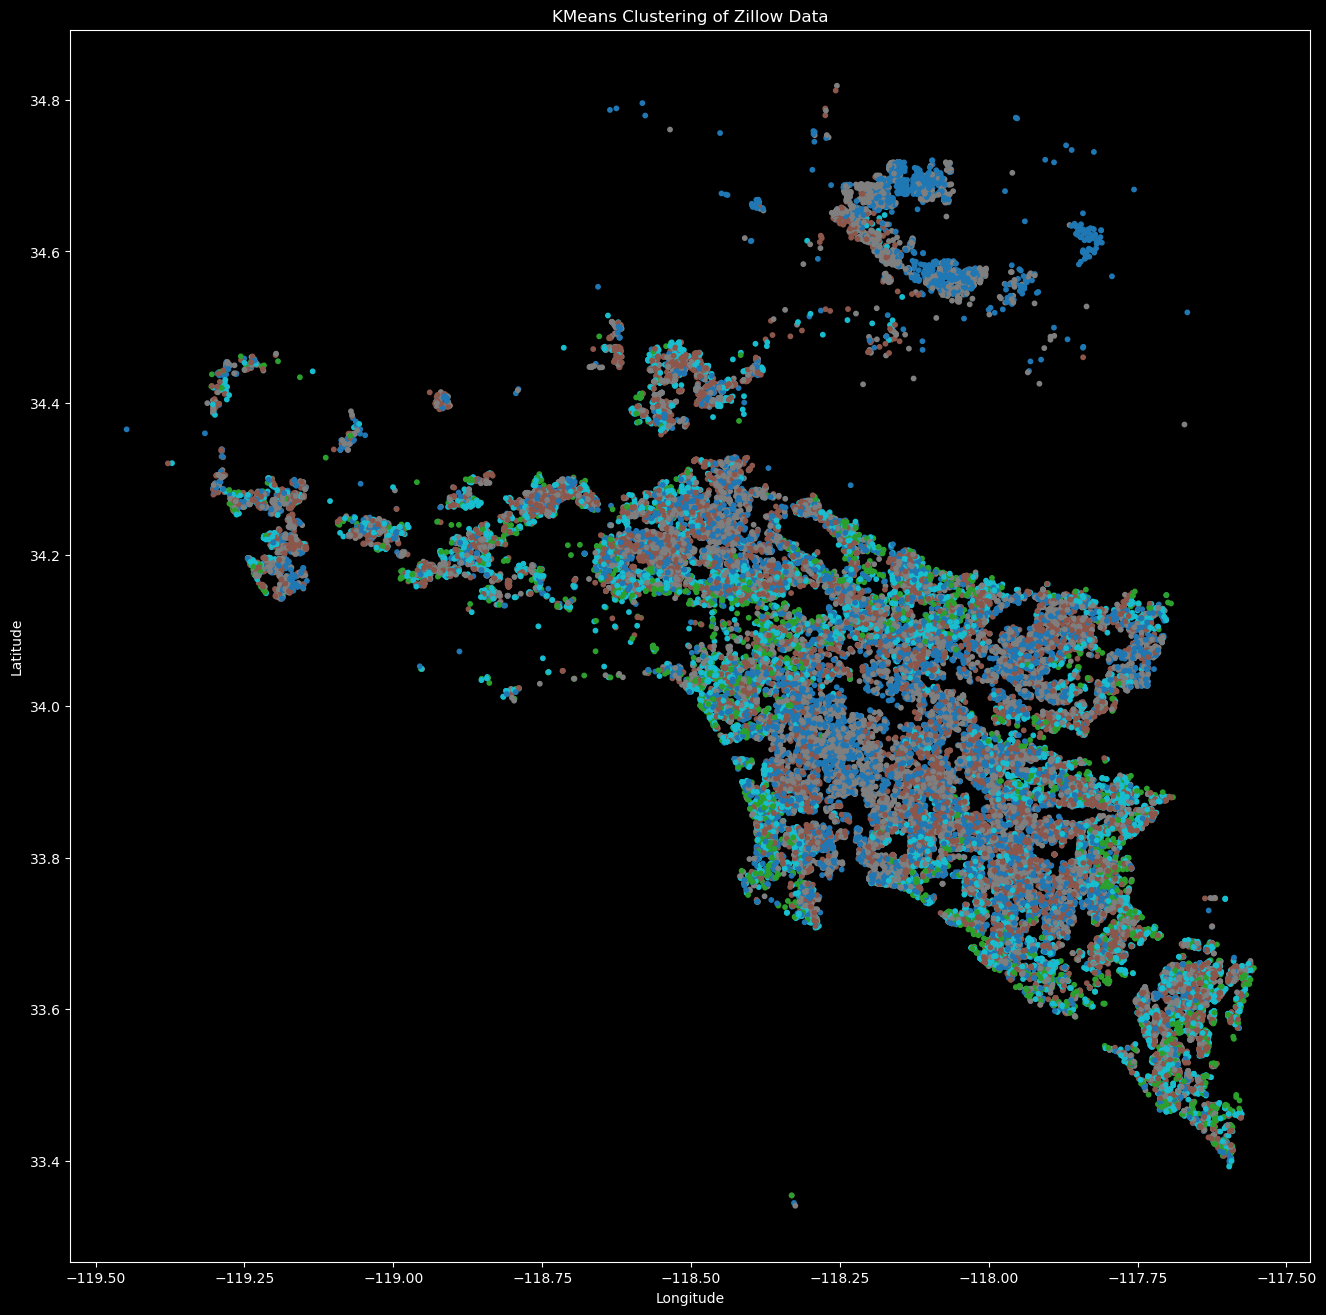

In [75]:
# Perform KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=123).fit(train_loc)

# Add the cluster labels to the train_loc
train_loc["cluster"] = kmeans.labels_

# Create a scatter plot of the train_loc, with color based on cluster label
plt.figure(figsize=[16, 16])
plt.scatter(train_loc["longitude"], train_loc["latitude"], c=train_loc["cluster"], cmap="tab10", s=10)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering of Zillow Data")
# Add a legend
plt.show()

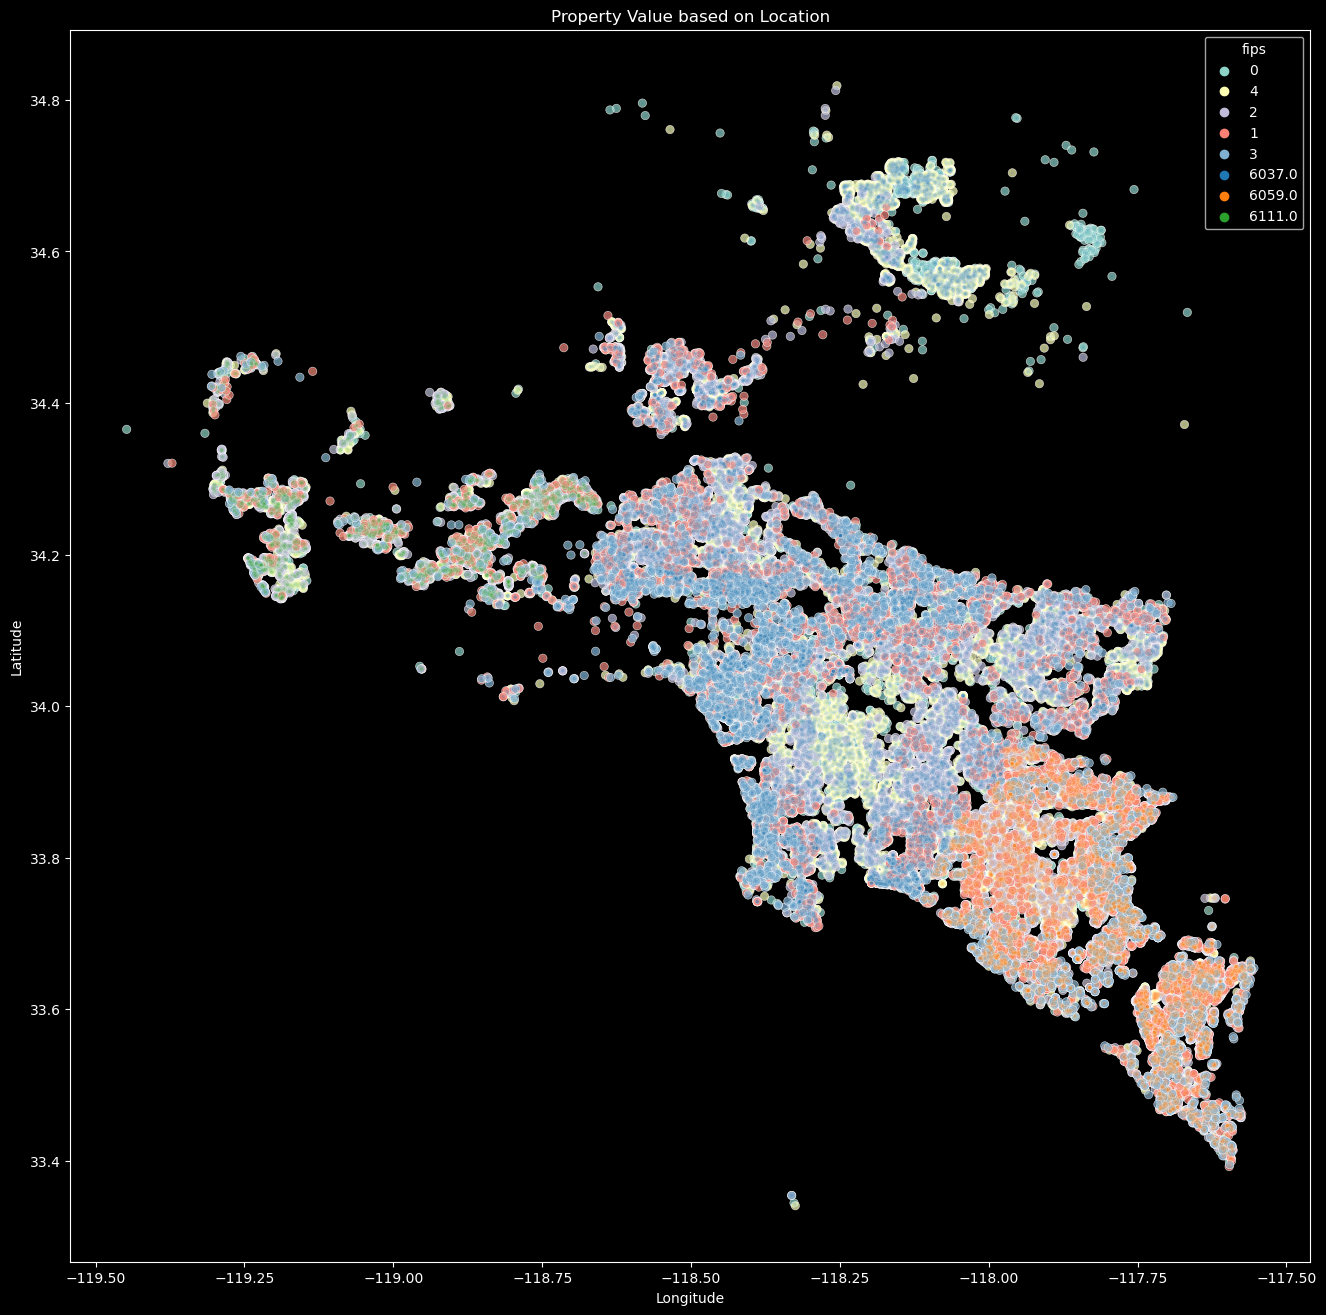

In [80]:
km = KMeans(n_clusters=5,random_state=42)
km.fit(train_loc)
train_loc = train_loc.assign(cluster = km.predict(train_loc))
train_loc.cluster = train_loc.cluster.astype(str)
# make the size
plt.figure(figsize=[16,16])
# plot prop value based on lat long
# make xy label scale smaller
p = train.copy()
p = p.assign(cluster=train_loc.cluster)
p = p.assign(lat=p.latitude/1000000)
p = p.assign(long=p.longitude/1000000)
p = p.sort_values('taxvaluedollarcnt')
# cluster kmeans
sns.scatterplot(data=p, y='lat', x='long', hue='cluster',alpha=.7,legend=True)
# generic legend example
sns.scatterplot(data=p,y='lat',x='long',hue=df['fips'],palette='tab10',alpha=.1,marker='.')
# label generic legend
# plt.legend(labels=['clusters','Prop Val','$400k','$800k','$1.2m','$1.6m'])
# give it a name
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property Value based on Location')
plt.show()